In [1]:
#!pip install cufflinks

from helpers import *
import xgboost as xgb
from sklearn.model_selection import train_test_split 
import seaborn as sns

In [2]:
stores = pd.read_csv("data/store.csv")
train = pd.read_csv("data/train.csv")
train.head()

C:\Users\MyLAP\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0


In [3]:
train.shape

(637774, 9)

In [4]:
print(stores.columns)

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
print(train.columns)

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')


In [6]:
train = date_convert(train)

In [7]:
print(train.columns)

Index(['Year', 'Quarter', 'Month', 'Week', 'Day', 'Date', 'Store', 'DayOfWeek',
       'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday'],
      dtype='object')


In [82]:
#merge stores into train
full_train = pd.merge(train, stores, how="left", on="Store")
full_train.head()

,Year,Quarter,Month,Week,Day,Date,Store,DayOfWeek,Sales,Customers,...,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013,1,1,1,1,2013-01-01,1115.0,2.0,0.0,0.0,...,1.0,d,c,5350.0,NaN,NaN,1.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,2013,1,1,1,1,2013-01-01,379.0,2.0,0.0,0.0,...,1.0,d,a,6630.0,NaN,NaN,0.0,NaN,NaN,NaN
2,2013,1,1,1,1,2013-01-01,378.0,2.0,0.0,0.0,...,1.0,a,c,2140.0,8.0,2012.0,0.0,NaN,NaN,NaN
3,2013,1,1,1,1,2013-01-01,377.0,2.0,0.0,0.0,...,1.0,a,c,100.0,6.0,2010.0,1.0,18.0,2010.0,"Feb,May,Aug,Nov"
4,2013,1,1,1,1,2013-01-01,376.0,2.0,0.0,0.0,...,1.0,a,a,160.0,8.0,2012.0,0.0,NaN,NaN,NaN


In [9]:
full_train.columns

Index(['Year', 'Quarter', 'Month', 'Week', 'Day', 'Date', 'Store', 'DayOfWeek',
       'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [16]:
full_train.dtypes

Year                                  int64
Quarter                               int64
Month                                 int64
Week                                  int64
Day                                   int64
Date                         datetime64[ns]
Store                               float64
DayOfWeek                           float64
Sales                               float64
Customers                           float64
Open                                float64
Promo                               float64
StateHoliday                         object
SchoolHoliday                       float64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                              float64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                   

# Dealing with **competition** features

In [17]:
full_train["CompetitionDistance"].describe()

count    616838.000000
mean       5412.023773
std        7673.525463
min          20.000000
25%         710.000000
50%        2330.000000
75%        6890.000000
max       75860.000000
Name: CompetitionDistance, dtype: float64

#### Is there a relationship between sales and competition distance?

In [ ]:
sns.lmplot(x="Sales", y="CompetitionDistance", data=full_train.iloc[:10000])

## **Date competition started**

### Combine month+year when competition started and create flag **"competition_active"**

In [84]:
full_train[[ "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]].head(5)
print(full_train["CompetitionOpenSinceYear"].describe())

count    422043.000000
mean       2008.673521
std           6.140044
min        1900.000000
25%        2006.000000
50%        2010.000000
75%        2013.000000
max        2015.000000
Name: CompetitionOpenSinceYear, dtype: float64


``there's a weird year there``

In [88]:
full_train['CompetitionOpenSinceYear'].value_counts(dropna=False, normalize=False)

NaN       215731
2013.0     45932
2012.0     45426
2014.0     38791
2005.0     34372
2010.0     30685
2009.0     29994
2011.0     29976
2008.0     29875
2007.0     26634
2006.0     26034
2015.0     21132
2002.0     15037
2004.0     12158
2003.0     10448
2001.0      8888
2000.0      5551
1999.0      4449
1990.0      2798
1994.0      1120
1995.0      1091
1961.0       565
1998.0       558
1900.0       529
Name: CompetitionOpenSinceYear, dtype: int64

In [89]:
#convert NAs to 0 so the conversion to int is possible
full_train["CompetitionOpenSinceYear"] = full_train["CompetitionOpenSinceYear"].fillna(1800)
full_train["CompetitionOpenSinceMonth"] = full_train["CompetitionOpenSinceMonth"].fillna(1)
# convert month/year to int
full_train["CompetitionOpenSinceMonth"] = full_train["CompetitionOpenSinceMonth"].astype(int).astype(str)
full_train["CompetitionOpenSinceYear"] = full_train["CompetitionOpenSinceYear"].astype(int).astype(str)

In [90]:
full_train[[ "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]].head(5)
print(full_train[[ "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]].dtypes)

CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
dtype: object


In [91]:
full_train['competition_started'] = full_train['CompetitionOpenSinceYear'] + '-' + full_train['CompetitionOpenSinceMonth']  + '-01' 

In [92]:
full_train['competition_started'].head()

0    1800-1-01
1    1800-1-01
2    2012-8-01
3    2010-6-01
4    2012-8-01
Name: competition_started, dtype: object

In [95]:
full_train['competition_started'] = pd.to_datetime(full_train["competition_started"])
full_train[[ "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "competition_started"]].head(5)

,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,competition_started
0,1,1800,1800-01-01
1,1,1800,1800-01-01
2,8,2012,2012-08-01
3,6,2010,2010-06-01
4,8,2012,2012-08-01


In [97]:
#set all dates prior 1900 to Nan
full_train.loc[full_train.competition_started < '1900-01-01', "competition_started" ] = np.nan
full_train[[ "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "competition_started"]].head(5)

,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,competition_started
0,1,1800,NaT
1,1,1800,NaT
2,8,2012,2012-08-01
3,6,2010,2010-06-01
4,8,2012,2012-08-01


In [99]:
full_train[[ "Date", "competition_started"]].head(5)

,Date,competition_started
0,2013-01-01,NaT
1,2013-01-01,NaT
2,2013-01-01,2012-08-01
3,2013-01-01,2010-06-01
4,2013-01-01,2012-08-01


In [100]:
full_train["competition_active"] = np.where(full_train["competition_started"] <= full_train["Date"], 1, 0)
# TO DO 
#full_train.loc[full_train.competition_started, "competition_active"]

In [102]:
full_train[[ "Date", "competition_started", "competition_active"]].head(15)

,Date,competition_started,competition_active
0,2013-01-01,NaT,0
1,2013-01-01,NaT,0
2,2013-01-01,2012-08-01,1
3,2013-01-01,2010-06-01,1
4,2013-01-01,2012-08-01,1
5,2013-01-01,2013-02-01,0
6,2013-01-01,2007-09-01,1
7,2013-01-01,NaT,0
8,2013-01-01,2010-08-01,1
9,2013-01-01,2009-07-01,1


# Exploring the relationships between customers and sales

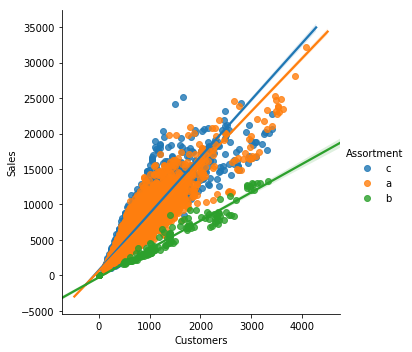

In [44]:
sns.lmplot(x="Customers", y="Sales", hue="Assortment", data=full_train.iloc[:20000,])

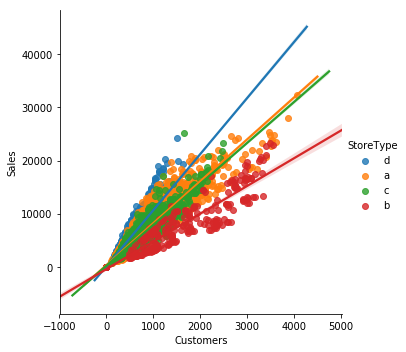

In [45]:
sns.lmplot(x="Customers", y="Sales", hue="StoreType", data=full_train.iloc[:20000,])